In [1]:
import numpy as np
import pandas
import math
import random
import os
import torch
import scipy.spatial.distance
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import plotly.graph_objects as go
import plotly.express as px

In [2]:
from path import Path
path = Path("./ModelNet10")

In [3]:
folders = [dir for dir in sorted(os.listdir(path)) if os.path.isdir(path/dir)]
classes = {folder: i for i, folder in enumerate(folders)};
classes

{'bathtub': 0,
 'bed': 1,
 'chair': 2,
 'desk': 3,
 'dresser': 4,
 'monitor': 5,
 'night_stand': 6,
 'sofa': 7,
 'table': 8,
 'toilet': 9}

In [4]:
def read_off(file):
    if 'OFF' != file.readline().strip():
        raise('Not a valid OFF header')
    n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces

In [6]:
with open(path/"bed/train/bed_0001.off", 'r') as f:
  verts, faces = read_off(f)

In [7]:
i,j,k = np.array(faces).T
x,y,z = np.array(verts).T

In [8]:
len(x)

2095

In [5]:
def visualize_rotate(data):
    x_eye, y_eye, z_eye = 1.25, 1.25, 0.8
    frames=[]

    def rotate_z(x, y, z, theta):
        w = x+1j*y
        return np.real(np.exp(1j*theta)*w), np.imag(np.exp(1j*theta)*w), z

    for t in np.arange(0, 10.26, 0.1):
        xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -t)
        frames.append(dict(layout=dict(scene=dict(camera=dict(eye=dict(x=xe, y=ye, z=ze))))))
    fig = go.Figure(data=data,
                    layout=go.Layout(
                        updatemenus=[dict(type='buttons',
                                    showactive=False,
                                    y=1,
                                    x=0.8,
                                    xanchor='left',
                                    yanchor='bottom',
                                    pad=dict(t=45, r=10),
                                    buttons=[dict(label='Play',
                                                    method='animate',
                                                    args=[None, dict(frame=dict(duration=50, redraw=True),
                                                                    transition=dict(duration=0),
                                                                    fromcurrent=True,
                                                                    mode='immediate'
                                                                    )]
                                                    )
                                            ]
                                    )
                                ]
                    ),
                    frames=frames
            )

    return fig

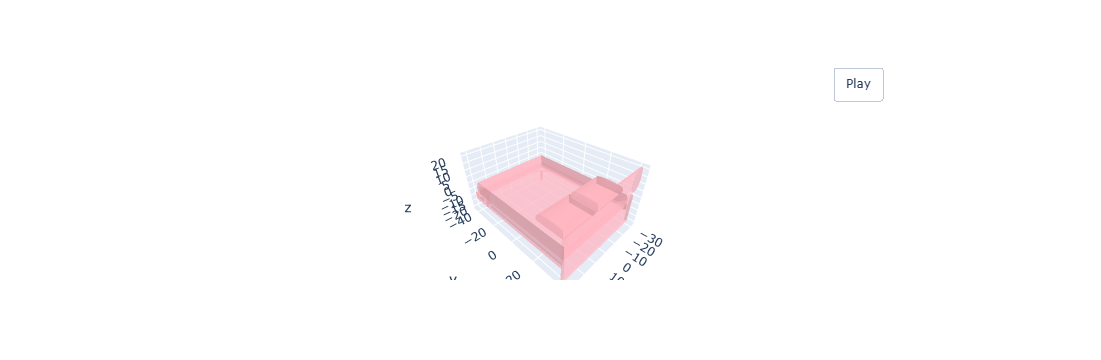

In [9]:
visualize_rotate([go.Mesh3d(x=x, y=y, z=z, color='lightpink', opacity=0.50, i=i,j=j,k=k)]).show()

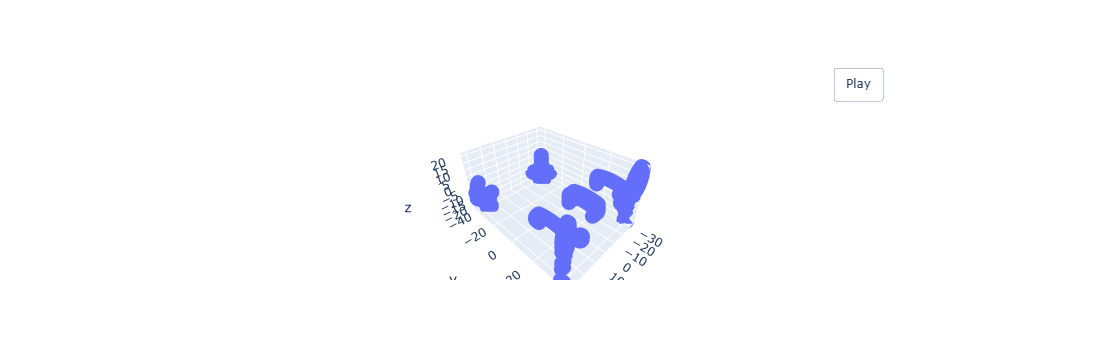

In [10]:
visualize_rotate([go.Scatter3d(x=x, y=y, z=z,
                                   mode='markers')]).show()

In [11]:
def pcshow(xs,ys,zs):
    data=[go.Scatter3d(x=xs, y=ys, z=zs,
                                   mode='markers')]
    fig = visualize_rotate(data)
    fig.update_traces(marker=dict(size=2,
                      line=dict(width=2,
                      color='DarkSlateGrey')),
                      selector=dict(mode='markers'))
    fig.show()
    

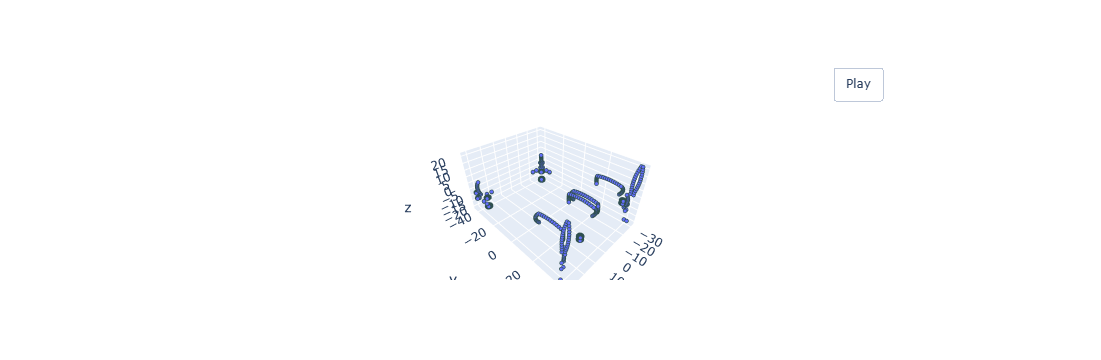

In [12]:
pcshow(x,y,z)

In [13]:
class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size
    
    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * ( side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        # barycentric coordinates on a triangle
        # https://mathworld.wolfram.com/BarycentricCoordinates.html
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
        return (f(0), f(1), f(2))
        
    
    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = (self.triangle_area(verts[faces[i][0]],
                                           verts[faces[i][1]],
                                           verts[faces[i][2]]))
            
        sampled_faces = (random.choices(faces, 
                                      weights=areas,
                                      cum_weights=None,
                                      k=self.output_size))
        
        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]],
                                                   verts[sampled_faces[i][1]],
                                                   verts[sampled_faces[i][2]]))
        
        return sampled_points


In [48]:
pointcloud = PointSampler(3000)((verts, faces))

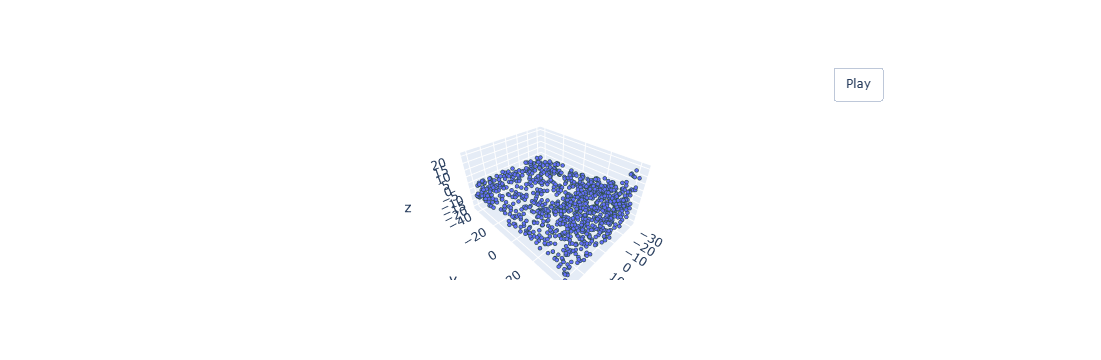

In [17]:
pcshow(*pointcloud.T)

In [18]:
class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud

In [19]:
norm_pointcloud = Normalize()(pointcloud)

In [32]:
norm_pointcloud.shape

(1024, 3)

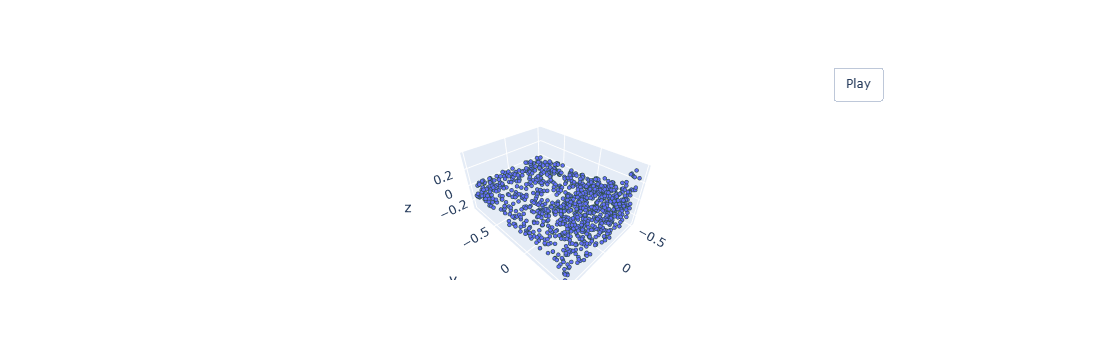

In [20]:
pcshow(*norm_pointcloud.T)

In [21]:
class RandRotation_z(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                               [ math.sin(theta),  math.cos(theta),    0],
                               [0,                             0,      1]])
        
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return  rot_pointcloud

In [22]:
rot_pointcloud = RandRotation_z()(norm_pointcloud)

In [31]:
rot_pointcloud.shape

(1024, 3)

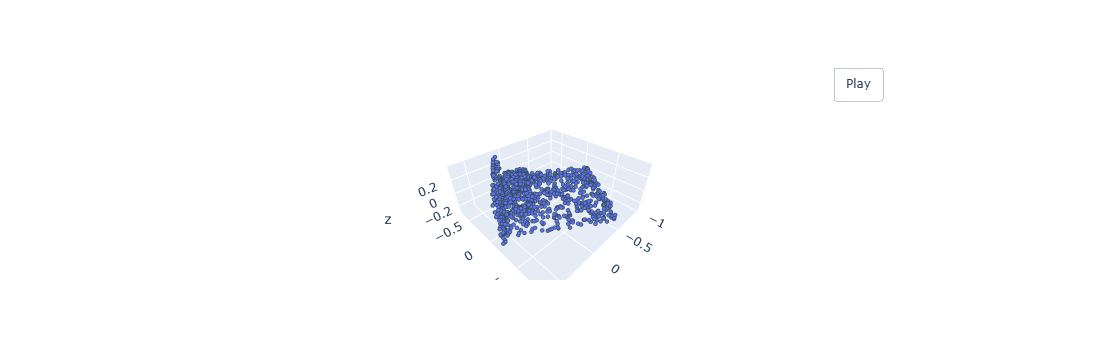

In [23]:
pcshow(*rot_pointcloud.T)

In [33]:
class RandomNoise(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0, 0.02, (pointcloud.shape))
    
        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud

In [34]:
noisy_rot_pointcloud = RandomNoise()(rot_pointcloud)

In [35]:
noisy_rot_pointcloud.shape

(1024, 3)

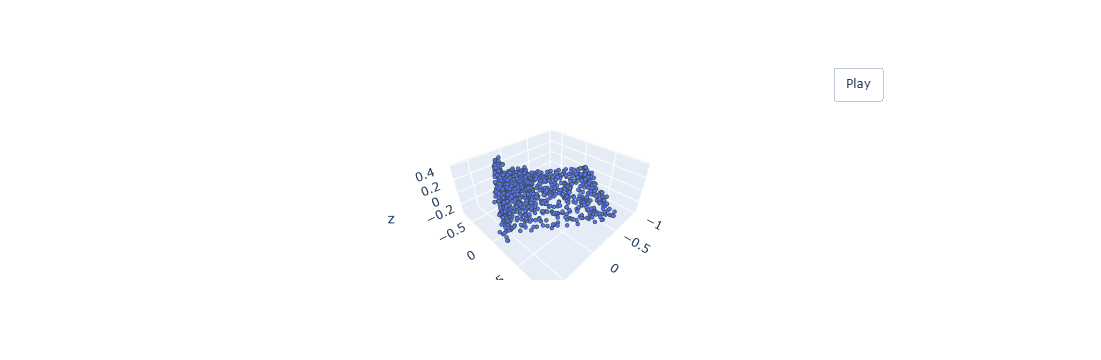

In [36]:
pcshow(*noisy_rot_pointcloud.T)

## 新的数据增强方法

In [90]:
#其实新的数据增强方法就是，尽可能模拟一些现实场景，比如桌子上有杂物，或者有一些物体遮挡等
#这个球的方法就是就是生成一个球体，然后随机在经过正则化的点云上，挖除和这个球体大小内部一样的点云（用这种方法模拟遮挡的效果），挖多了补点，使得输入的size为[1024，3]
#RandomShift和RandomScale分别是随机对点云进行一定程度的位移和对点的大小放缩
#通过累加这三个操作使得一定程度上“破坏”了点云内部的排布，一定程度上提高了模型的对点云更多特征的学习，有助于鲁棒性的提高


def generate_sphere(center, radius, num_points):
    """生成一个球体的点云"""
    u = np.random.uniform(0, 1, num_points)
    v = np.random.uniform(0, 1, num_points)
    
    theta = 2 * np.pi * u
    phi = np.arccos(2 * v - 1)

    # 根据球坐标系转换为三维笛卡尔坐标系
    x = center[0] + radius * np.sin(phi) * np.cos(theta)
    y = center[1] + radius * np.sin(phi) * np.sin(theta)
    z = center[2] + radius * np.cos(phi)

    return np.column_stack((x, y, z))

def apply_occlusion(pointcloud, sphere_center, sphere_radius):
    """将生成的球体和原本的点云数据合成，将球体内的点云数据删除"""
    distances = np.linalg.norm(pointcloud - sphere_center, axis=1)
    occluded_pointcloud = pointcloud[distances > sphere_radius]
    return occluded_pointcloud

def pad_or_crop(pointcloud, target_size):
    """填充或裁剪点云到目标大小"""
    current_size = pointcloud.shape[0]
    if current_size < target_size:
        padding = np.zeros((target_size - current_size, pointcloud.shape[1]), dtype=pointcloud.dtype)
        return np.vstack((pointcloud, padding))  # 在第一个维度上堆叠
    elif current_size > target_size:
        return pointcloud[:target_size]  # 裁剪到目标大小
    return pointcloud

class Sphere_Occlusion(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape) == 2
        random_index = np.random.randint(0, pointcloud.shape[0])
        sphere_center = pointcloud[random_index]
        
        sphere_radius = 0.5
        num_sphere_points = 500

        sphere_pointcloud = generate_sphere(sphere_center, sphere_radius, num_sphere_points)
        
        occluded_pointcloud = apply_occlusion(pointcloud, sphere_center, sphere_radius)

        # 确保输出的点云大小为 [1024, 3]
        return occluded_pointcloud

In [91]:
#这个输出效果是没有，固定大小的
occ_pointcloud = Sphere_Occlusion()(norm_pointcloud)

In [92]:
occ_pointcloud.shape

(579, 3)

In [93]:
pcshow(*occ_pointcloud.T)

In [112]:
# 这个是有固定大小的
class Sphere_Occlusion1(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape) == 2
        random_index = np.random.randint(0, pointcloud.shape[0])
        sphere_center = pointcloud[random_index]
        
        sphere_radius = 0.3
        num_sphere_points = 400

        sphere_pointcloud = generate_sphere(sphere_center, sphere_radius, num_sphere_points)
        
        occluded_pointcloud = apply_occlusion(pointcloud, sphere_center, sphere_radius)

        # 确保输出的点云大小为 [1024, 3]
        return pad_or_crop(occluded_pointcloud, 1024)

In [113]:
occ_pointcloud1 = Sphere_Occlusion1()(norm_pointcloud)

In [114]:
occ_pointcloud1.shape

(1024, 3)

In [115]:
pcshow(*occ_pointcloud1.T)

In [66]:
class RandomShift(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape) == 2
        shift_range = 0.1

        shifts = np.random.uniform(-shift_range, shift_range, pointcloud.shape)
        shifted_pointcloud = pointcloud + shifts
        
        # 确保输出的点云大小为 [1024, 3]
        return shifted_pointcloud



In [81]:
rand_pointcloud = RandomShift()(norm_pointcloud)

In [82]:
rand_pointcloud.shape

(1024, 3)

In [83]:
pcshow(*rand_pointcloud.T)

In [116]:
class RandomScale(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape) == 2
        scale_low = 0.8
        scale_high = 1.25
        scales = np.random.uniform(scale_low, scale_high, (pointcloud.shape[0], 1))
        scaled_pointcloud = pointcloud * scales
        
        # 确保输出的点云大小为 [1024, 3]
        return scaled_pointcloud

In [117]:
rands_pointcloud = RandomScale()(norm_pointcloud)

In [119]:
rands_pointcloud.shape

(1024, 3)

In [118]:
pcshow(*rands_pointcloud.T)

In [120]:
rand_pointcloud1 = RandomShift()(occ_pointcloud1)

In [121]:
pcshow(*rand_pointcloud1.T)

In [122]:
rands_pointcloud1 = RandomScale()(rand_pointcloud1)

In [123]:
pcshow(*rands_pointcloud1.T)